## Packages

In [164]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


## Importing Data

##### Custom Dataset Class

In [165]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, file, scaler):
    self.df = pd.read_csv(file)
    self.sc = scaler
    self.sc.fit(self.df)

  def __len__(self):
    return self.df.shape[0]
  
  def __getitem__(self, idx):
    raw = self.df.iloc[idx].values
    if type(idx) == int:
      raw = raw.reshape(1, -1)
    raw = self.sc.transform(raw)
    data = torch.tensor(raw[:, 1:], dtype=torch.float32) # Features
    label = torch.tensor(raw[:, 0], dtype=torch.float32) # Label
    return data, label

##### Importing Data and Scaling each based on their respective training data

In [166]:
""" Center Surround Data """
center_surround_train_df = pd.read_csv("./center_surround_train.csv")
center_surround_scaler = MinMaxScaler().fit(center_surround_train_df)
center_surround_train_data = CustomDataset('./center_surround_train.csv', center_surround_scaler)
center_surround_test_data = CustomDataset('./center_surround_test.csv', center_surround_scaler)
center_surround_valid_data = CustomDataset('./center_surround_valid.csv', center_surround_scaler)

center_surround_train_loader = DataLoader(center_surround_train_data, batch_size=32, shuffle=True)
center_surround_test_loader = DataLoader(center_surround_test_data, batch_size=32, shuffle=True)

""" Spiral Data """
spiral_train_df = pd.read_csv("./spiral_train.csv")
spiral_scaler = MinMaxScaler().fit(spiral_train_df)
spiral_train_data = CustomDataset('./spiral_train.csv', spiral_scaler)
spiral_test_data = CustomDataset('./spiral_test.csv', spiral_scaler)
spiral_valid_data = CustomDataset('./spiral_valid.csv', spiral_scaler)

spiral_train_loader = DataLoader(spiral_train_data, batch_size=32, shuffle=True)
spiral_test_loader = DataLoader(spiral_test_data, batch_size=32, shuffle=True)

""" Two Gaussians Data """
two_gaussians_train_df = pd.read_csv("./two_gaussians_train.csv")
two_gaussians_scaler = MinMaxScaler().fit(two_gaussians_train_df)
two_gaussians_train_data = CustomDataset('./two_gaussians_train.csv', two_gaussians_scaler)
two_gaussians_test_data = CustomDataset('./two_gaussians_test.csv', two_gaussians_scaler)
two_gaussians_valid_data = CustomDataset('./two_gaussians_valid.csv', two_gaussians_scaler)

two_gaussians_train_loader = DataLoader(two_gaussians_train_data, batch_size=32, shuffle=True)
two_gaussians_test_loader = DataLoader(two_gaussians_test_data, batch_size=32, shuffle=True)

""" XOR Data """
xor_train_df = pd.read_csv("./xor_train.csv")
xor_scaler = MinMaxScaler().fit(xor_train_df)
xor_train_data = CustomDataset('./xor_train.csv', xor_scaler)
xor_test_data = CustomDataset('./xor_test.csv', xor_scaler)
xor_valid_data = CustomDataset('./xor_valid.csv', xor_scaler)

xor_train_loader = DataLoader(xor_train_data, batch_size=32, shuffle=True)
xor_test_loader = DataLoader(xor_test_data, batch_size=32, shuffle=True)



In [167]:
for X, y in center_surround_train_loader:
  for i in range(3):  
    print("Example #: ", i + 1)
    print("Features: ", X[i])
    print("Label: ", y[i])
  break  

Example #:  1
Features:  tensor([[0.5221, 0.4388]])
Label:  tensor([0.])
Example #:  2
Features:  tensor([[0.3444, 0.2898]])
Label:  tensor([1.])
Example #:  3
Features:  tensor([[0.5908, 0.6160]])
Label:  tensor([0.])


## Modeling

##### Feed Forward Neural Network

In [168]:
class SimpleFFNN(nn.Module):
  def __init__(self, size_in, size_out, hidden_n):
    super(SimpleFFNN, self).__init__()
    self.linear_1 = nn.Linear(size_in, hidden_n)
    self.linear_activation = nn.Tanh()
    self.output = nn.Linear(hidden_n, size_out)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.linear_activation(x)
    x = self.output(x)
    return x

##### Training the Model and Testing the model

In [169]:
def train(dataloader, model, loss_func, optimizer):
  """
  Parameters
  ----------
  dataloader: torch.utils.data.DataLoader instance for training data
  model: torch.nn.Module of neural model
  loss_func: torch.nn.??? where ??? is your loss function you want
  optimizer: torch.optim.??? where ??? is your gradient optimizer
  
  Returns
  -------
  The training loss as an array
  """
  model.train()
  running_loss = 0.0

  train_loss = []
  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()

    y = y.squeeze().long()    
    logits = model(X.squeeze(1))  # Outputs: [32, 2], y: [32,]
  
    loss = loss_func(logits, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if batch % 10 == 0:
      train_loss.append(running_loss)
  return train_loss

def test(dataloader, model, loss_func):
  """
  Parameters
  ----------
  dataloader: torch.utils.data.DataLoader instance for training data
  model: torch.nn.Module of neural model
  loss_func: torch.nn.??? where ??? is your loss function you want
  
  Returns
  -------
  The test loss as an array
  """
  model.eval()
  running_loss = 0.0

  test_loss = []
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      logits = model(X.squeeze(1))
      y = y.squeeze().long()
      loss = loss_func(logits, y).item()
      running_loss += loss

      if batch % 10 == 0:
        test_loss.append(running_loss)
  return test_loss

##### Looking at loss of each set over epochs

In [170]:
def train_and_test_wrapper(training_set, test_set, title=""):
  """
  Trains the model at each epoch and calculates
  the loss over both the training set and the test set
  at each epoch. Then plots the results
  """
  model = SimpleFFNN(2, 2, hidden_n=5)
  lr = 1e-3
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  epochs = 100

  epoch_list = [i for i in range(epochs)] # [0, 1, ... n epochs]
  train_loss = [] # [loss epoch 0, loss epoch 1, .... loss epoch n]
  test_loss = []  # [loss epoch 0, loss epoch 1, .... loss epoch n]
  for _ in range(epochs):
    train_loss.append(train(training_set, model, loss_func, optimizer)[0]) # TRAINING LOSS
    test_loss.append(test(test_set, model, loss_func)[0]) # TESTING LOSS

  plt.plot(epoch_list, train_loss, label="Training Loss")
  plt.plot(epoch_list, test_loss, label="Testing Loss")
  plt.title(title)
  plt.legend()
  plt.show()

##### Charts

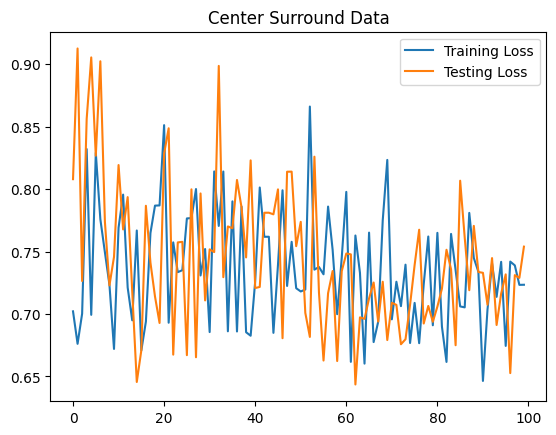

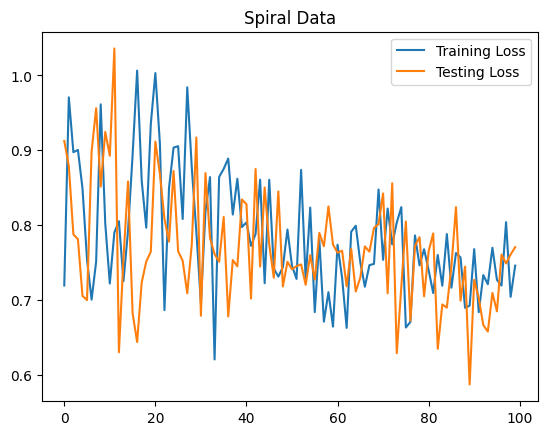

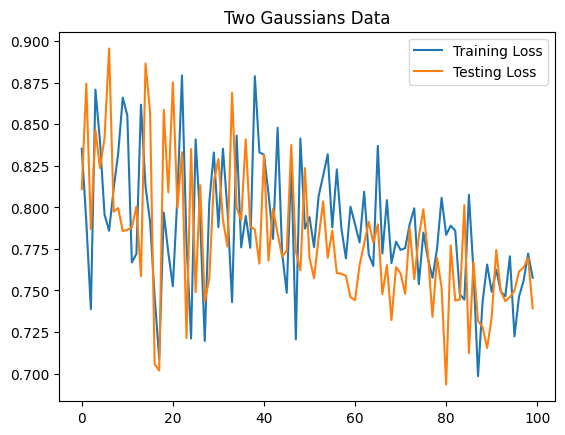

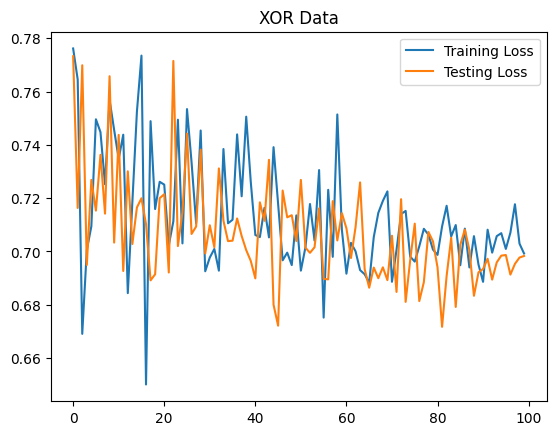

In [171]:
train_and_test_wrapper(center_surround_train_loader, center_surround_test_loader, title="Center Surround Data") 
train_and_test_wrapper(spiral_train_loader, spiral_test_loader, title="Spiral Data") 
train_and_test_wrapper(two_gaussians_train_loader, two_gaussians_test_loader, title="Two Gaussians Data") 
train_and_test_wrapper(xor_train_loader, xor_test_loader, title="XOR Data") 